## Context
KOV-4205 - Incident Impact - Duration

- Comparison of the overall distribution from the model with real events


## Limitations

1. Scope: only covers F1000 companies
2. Availabiliy model data: only available for companies where a `financial_quantification_input.json` file is generated (currently 948/1000)
3. Data quality 
    - the classification of availability events in both the `model_events` and `vcdb` tables was not reliable and these events had to be manually annotated prior to use. 
    - the field `availability_duration_days` in the `model_events` table had values that were not correctly calculated. A correction had to made in the analysis to account for this. 

## Data

1. F1000 model data - table - `dna-db.postgres.model_events`
    - model version: v2022.2.3 FQ model
    - run date: 2022-04-20
2. Events data 
    - table - `dna-db.postgres.data_sources_events`
    - table - `dna-db.postgres.data_sources_entities`
    - table - `dna-db.data_sources.vcdb`

## Conclusion
1. Advisen data is from a similar population to the model data is quite sparse for interruption events (with a duration).
Separating availability duration from campaign duration can be challenging.
2. Veris VCDB contains broader range of companies within the same timeframe (2010-2020), and more availability events.
3. Mean duration of interruption (days) - F1OOO Kovrr model (3.01), Advisen (5.14), VCDB (4.18)
4. Coveware’s Ransomware report highlights a mean time of 15-23 days. The time to ‘completely resolve’ a ransomware incident.The model mean time as it represents the time to be able to transact again

## Testing Detail

### Duration



In [2]:
# builds the connection to azure:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sentence_transformers import SentenceTransformer
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
import joblib
import xgboost
# import custom modules:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib._get_data import *

#set colour palette for seaborn
colors = set_colours()
sns.set_palette(sns.color_palette(colors))
#get engine for sql queries
engine=get_engine()


server connected


In [3]:
pd.set_option('display.precision',3)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_info_rows',100)
pd.set_option('display.max_info_columns',50)
pd.set_option('display.max_colwidth',0)
pd.options.display.float_format='{:,.2f}'.format

In [4]:
# get model_version
model_version = pd.read_sql_query('''select value from model_metadata where item = 'model_version' ''', engine)
model_version = model_version.iloc[0][0]
model_version

'v2022.2.3'

### Get model data

In [5]:
# get model_data
df_model = pd.read_sql_query('''
    select
        run_id::text as entity,
        event_duration/(60*24) as duration,
        event_type as event_type
    from
        model_events
''', engine)
df_model.pop('entity')
df_model['source'] = 'model'


### Get Events data

#### Investigate Advisen events - including events with availability duration >31 days

In [6]:
events = read_f1k_table()

server connected


In [8]:
#fill missing event names with 'None' - cannot create embeddings for null values
events['event_name'] = events['event_name'].fillna('None')

In [9]:
def event_classifier(df, event_column, path_to_model):
    """classify events as availability[1] or non-availability[0] based on pre-trained model"""
    df = df.copy()
    model = SentenceTransformer('sentence-transformers/stsb-distilbert-base')
    embeddings = [model.encode(x) for x in tqdm(df[event_column].tolist())]
    pca = PCA(n_components = 20)
    X = pca.fit_transform(embeddings)
    best_clf = joblib.load(path_to_model)
    y_pred = best_clf.predict(X)
    df['predictions'] = y_pred
    return df

In [10]:
predicted_events =  event_classifier(df=events, event_column='event_name',path_to_model='data/description_classifying_model.sav')

  0%|          | 0/4317 [00:00<?, ?it/s]

In [11]:
predicted_events['predictions'].value_counts()

0    4312
1    5   
Name: predictions, dtype: int64

In [12]:
#availability events
predicted_events.loc[predicted_events['predictions']==1,['availability_duration_days','breach_duration_days','event_name']]

,availability_duration_days,breach_duration_days,event_name
293,NaN,NaN,"Abercrombie & Fitch Co., TCPA Violation, 2019"
296,NaN,NaN,"Johns Manville Corp. and Automatic Data Processing, Inc., Unintentional Disclosure, 2019"
1195,NaN,NaN,Attunity Leaked Data 2019
1887,NaN,NaN,"Fidelity National Information Services, Inc. 2011"
2883,NaN,NaN,"Charter Communications, Inc. TCPA & MTCCCA Violations, 2019"


In [13]:
#non-availability events with an availability duration populated
predicted_events.loc[(predicted_events['predictions']==0) & (predicted_events['availability_duration_days'].notnull()),['company_name','availability_duration_days','breach_duration_days','event_name']].sort_values('availability_duration_days')

,company_name,availability_duration_days,breach_duration_days,event_name
2275,Dell Inc.,0.00,NaN,None
2240,Dell Inc.,0.00,NaN,None
2267,The Methodist Hospital,0.00,NaN,None
4303,"Under Armour, Inc.",0.00,NaN,None
2377,"Autozone, Inc.",0.00,NaN,None
2403,Adobe Systems Incorporated,0.00,NaN,None
2404,"Northside Hospital, Inc.",0.00,NaN,None
2708,Southwest Airlines Co.,0.00,NaN,Cyber - Southwest Airlines Co.
2932,Orlando Health,0.00,NaN,None
2934,Overstock.Com Inc,0.00,NaN,None


In [14]:
#fix the availability_duration_days - 0 day values calculated instead on nan
predicted_events['availability_duration_days_fixed'] = predicted_events['event_end_date'] - predicted_events['event_start_date']
predicted_events['availability_duration_days_fixed'] = predicted_events['availability_duration_days_fixed'].dt.days

In [28]:
#curated-events - advisen events that are likely availability events - manual annotation
availability_event_ids = [36744,3439,28762,8299,44321,47261,27619, 12681,54226,16055,15842,1398,21726,21729,15850,47715,3997,51734,16060,46479,16549,63570,13826,27620,16724,14498,33910,8211,7663,63814,48399,63898,23300]
predicted_events.loc[predicted_events['event_id'].isin(availability_event_ids),'annotated_availability_events'] = True
predicted_events['source'] = 'Advisen'

In [29]:
#Advisen data
advisen_events = predicted_events.loc[predicted_events['annotated_availability_events']==True,['availability_duration_days_fixed','source']]

In [59]:
annotated_event_ids=['36744','3439','28762','8299','44321','47261','27619', '12681','54226','16055','15842','1398','21726','21729','15850','47715','3997','51734','16060','46479','16549','63570','13826','27620','16724','14498','33910','8211','7663','63814','48399','63898','23300']
predicted_events['event_id_modified']=predicted_events['event_id'].str.replace('\[|\]','')
predicted_events[predicted_events['event_id_modified'].isin(annotated_event_ids)]

,dedup_id,event_id,source_name,source_id,company_instance_id,insured_exposure,uninsured_exposure,event_type,event_name,event_start_date,is_event_start_date_estimated,event_end_date,breach_duration_days,availability_duration_days,event_aware_date,event_disclosure_date,affected_products,compromised_data_types,compromised_data_amount,attack_vector,mitre_attack_techniques,cve,malware_name,actor_name,actor_mitre_id,actor_type,impact_type_confidentiality,impact_type_integrity,impact_type_availability,impact_type_extortion,number_of_companies_affected,lost_income_cost_millions_usd,liability_third_party_cost_millions_usd,liability_first_party_cost_millions_usd,injury_cost_millions_usd,property_cost_millions_usd,response_cost_millions_usd,regulatory_costs_millions_usd,total_cost_millions_usd,extortion_amount_millions_usd,extortion_paid_millions_usd,extortion_paid,other_costs_millions_usd,settlement_amount_paid_millions_usd,created_at,company_instance_id,company_unique_id,company_name,company_name_aliases,company_domain,company_domain_aliases,company_employee_number,company_employee_range,company_revenue_millions_usd,company_revenue_range,company_country,company_country_code,company_state,company_city,company_zip,company_address,company_type,company_naics,company_sic,company_industry,company_greynoise_results,company_parent_name,company_parent_domain,company_ultimate_parent_name,company_ultimate_parent_domain,created_at,predictions,availability_duration_days_fixed,annotated_availability_events,source,event_id_modified
831,13370,[16549],['advisen'],['50465' '50463'],16549,NaN,NaN,['Data Breach'],Compass Bank FCRA Violation 2012,2012-02-27,False,NaT,NaN,NaN,2013-01-08,NaT,None,['PII'],None,None,None,None,None,None,None,['Internal - Organization'],True,None,None,None,1.00,NaN,0.00,0.00,0.00,0.00,NaN,0.00,NaN,NaN,NaN,None,NaN,NaN,2022-06-22 16:14:09.951025,16549,1235,Compass Bank,None,www.bbva.com,None,"8,000.00",5001 to 10000,"4,041.45",$2B-$10B,USA,US,AL,Birmingham,35233-2011,15 20th St S Ste 100,None,"522,110.00","6,029.00","Commercial banks, nec",0,None,None,None,None,2022-06-20 21:01:09.567272,0,NaN,NaN,Advisen,16549


### vcdb data

In [60]:
vcdb_availability = read_vcdb_events()

server connected


In [61]:
profile_vcdb_events = ProfileReport(vcdb_availability, title='vcdb_events_EDA',minimal=True)
profile_vcdb_events.to_file('data/vcdb_events_EDA.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
def convert_duration_to_days(df, unit_col, val_col, create_col):
    """convert duration to days based on unit column"""
    df = df.copy()
    mapping = {'Days':1, 'Hours':1/24, 'Weeks':7, 'Minutes':1/(24*60), 'Months':30, 'Years':365, 'Never':np.nan}
    for units,values in mapping.items():
        df.loc[df[unit_col]==units,create_col]=df[val_col]*values
    return df

In [63]:
vcdb_availability_duration_fixed = convert_duration_to_days(df = vcdb_availability, unit_col='attribute_availability_duration_unit',val_col='attribute_availability_duration_value',create_col='availability_duration_days')

In [64]:
predicted_vcdb_events =  event_classifier(df=vcdb_availability_duration_fixed, event_column='summary',path_to_model='data/description_classifying_model.sav')

  0%|          | 0/125 [00:00<?, ?it/s]

In [65]:
#curated-events - vcdb events that are likely availability events - manual annotation
availability_event_ids = [ "B040AF5E-E527-4193-A95D-01592F7B6FA1" , "48789bf0-c8f4-11e9-9c16-3f32faecab86" , "7C360C78-68FA-483D-B354-1A74E994F692" , "9D6229B5-D8F4-4B6B-91FF-BBF8A9B7061D" , "f82ee030-de12-11e9-92e6-b7a271e742aa" , "2DE6C6B9-260C-4F42-B870-0D30BB87962A" , "90778723-9EEB-42D3-A3C1-1E45360B926C" , "C2440E4F-0A77-429D-9F19-3390D484C01E" , "B1232E61-68AC-4B75-897E-20961AE49E6C" , "5EC74643-0F36-4F2A-BEBD-98A0110162C2" , "9C2C2351-AC07-4EFD-9964-2EB451C8654D" , "10b98c60-15de-11ea-ba54-075d8b11bbd2" , "AEF76670-CA82-469B-BE0A-B5EFA2381D0F" , "66650162-DAB0-4C82-A32A-0DEC83735370" , "1EF9CAD4-E31D-4506-83FD-7DC218929CB3" , "E8D5A222-6138-4997-A50D-127DC7A4963D" , "13188709-C0E4-43C8-881F-F00F330353E1" , "B4883BFB-38A6-49FE-9766-5E53C020D1BA" , "7710424D-5278-4C35-857F-732E8F0BF30F" , "A4146679-35A9-45C5-A788-5E58E49C331E" , "61BCDB75-75F7-4B2D-9BEB-53E126E667DD" , "59CA466B-70E9-4F28-A6D8-4102BBE87197" , "89B5C0FB-ED32-46D4-911C-8370B9EA4549" , "48B10AED-D009-43FE-A6EC-43347E2CFE14" , "9242C268-4AB8-4B18-B3B6-316FEED63778" , "B64B656E-64EA-46DD-A7BC-8BAAB6595E8B" , "98C6344E-7D1A-42B8-9F06-76D5643B15A6" , "A695E842-89AD-4547-B767-076CF8EE6205" , "F68EF982-454F-46D2-8545-85FE1E908CD7" , "7866B7EE-A40E-463B-A4BD-B0DEC7A3DB94" , "973575F9-F725-4B3F-B497-AE648836756E" , "E5D427C6-B22B-47E8-8A3A-9FF7B99C07EC" , "19E55526-D875-4A1A-9E6D-D454DD72508F" , "15561EDD-EE92-4866-BDFC-6548969EC5BA" , "18bfa490-07e5-11eb-9be5-67f56bbd8cb4" , "12679140-8aae-11e8-874b-dd84fb61b260" , "B356D3E7-A041-427F-9477-D25AF2F6E9C6" , "E68565A5-6CB5-411B-A952-4EA430D4531C" , "e4d7cfc0-761c-11e7-9d88-ab89f89c69db" , "950bc800-de09-11e9-92e6-b7a271e742aa" , "16618345-9E76-4D8E-9674-BF1E07C3C56F" , "AE0AF7D6-B863-4605-A5D3-8087ACD7CA56" , "78ee4940-6c82-11e7-8419-7d473c8dcba3" , "F47262C8-EADB-4358-8282-A2A0AFAA7FE9" , "fce9a620-85f6-11e8-ae9b-a1b647b0d464" , "AE263091-A728-4455-88D5-4EBD1F8B480E" , "6fbb5ec0-ce65-11e9-b4e5-4769cce343a0" , "376F9AAD-7EA1-4B15-8BDC-EE457BFCF152" , "AE327DA0-FFE9-4577-A894-F7C972E401A0" , "FCA43278-6D87-4ABF-A918-3FA416F7551C" , "553E7277-4C8B-4210-A3C0-8FE8FEEE5B65" , "2DFBAD24-12AD-4256-85FC-D8EC2D8C71FB" , "07c93380-1061-11ea-9257-5f79bcff5761" , "2640A6B4-7F2D-43AF-93E6-DD9CBE19658F" , "B81E60C1-5020-4DEA-9CF4-BABF44C3D1DF" , "ef191cc0-9748-11e8-8342-0f8f10fcd812" , "91A96A06-599D-4F10-8A43-909D1EC7D0F0" , "5BC06D9F-21C1-4725-AE20-B27355CAEB72" , "01468660-8ea4-11e8-8003-e3ff5269fee2" , "E2CFF8F0-7478-497A-B0FE-07D97E8BBA9E" , "504ff4e0-0fc6-11ea-997d-ff527b87f439" , "DC18C7D0-E10A-4F1F-A242-D95572D5AF8C" , "1F3704A1-771D-4E77-9B71-2C76DA743381" , "4F2D1D4A-3FD6-46DC-B2B8-D296DEE0463D" , "24CDDAD9-E931-44F8-8AF8-21AE8ACC426C" , "268E0C6F-BA8B-43F4-B980-BB135AF9F98D" , "38c01350-72f7-11e7-a859-bd14321ac1c3" , "438607BB-8961-417E-B895-F68F9A396569" , "BD71EF22-F735-4AE9-A9A4-3F39DABF6169" , "9281EA6E-9A68-4074-8F31-9FE98076972E" , "AF108731-F2F5-4B1E-B75E-0FC9FFFDE9D9" , "E7A11807-6EE6-47AB-88BD-0C56682BABEC" , "BB7833CC-EA6B-47C5-864B-62D775458F45" , "BAF6581E-08D3-4AAB-9757-0C1CA854F4EF" , "E6F5FEBB-A2A3-43B0-8283-AED0F67A9841" , "CBC156D3-9481-4E80-8A80-B77FD64F1F5A" , "cb5f7460-89a1-11e7-bf1d-81579668407a" , "CACCA87D-8FC7-4722-81D7-C84BC9F45C88" , "788C3B36-0C11-4398-AA3C-F8E70787DEF3" , "4D630A26-B2FC-4A39-BD6E-7D7DA968B17C" , "4AFFBDC8-59BE-46A8-B9B9-EA4337770B8D" , "C108305E-4753-4279-A5AA-BB5F11C0F9B8" , "f17d2ad0-c55a-11e7-8460-859aaa890f03" , "0385F25B-DDEF-4838-AAA4-8539F6462DBE" , "88409FC9-A75B-4F77-959F-04CDB4EE179B" , "a2d88230-0c70-11ea-bb2f-edf349509116" , "5B4505C3-A9DD-453D-92DC-EA1AA8AA2996" , "8b0b0b80-c335-11e8-be54-d7fc81504f5e" , "43702e60-2385-11eb-b77f-316b5c5dd5eb" , "aca94ed0-8116-11e7-9cfb-2f8f443557c3" , "2B6D006F-BE4B-4240-B011-226DB23247E5"]
vcdb_availability_duration_fixed.loc[vcdb_availability_duration_fixed['incident_id'].isin(availability_event_ids),'annotated_availability_events'] = True
vcdb_availability_duration_fixed['source'] = 'VCDB'

In [66]:
#aggregate event data from Advisen and VCDB
advisen_events = predicted_events.loc[predicted_events['annotated_availability_events']==True,['availability_duration_days_fixed','source']].rename(columns={'availability_duration_days_fixed':'availability_duration_days'})
vcdb_events = vcdb_availability_duration_fixed.loc[(vcdb_availability_duration_fixed['annotated_availability_events']==True) & (vcdb_availability_duration_fixed['timeline_incident_year'].between(left=2010, right=2020,inclusive='both')),['availability_duration_days','source']]
events_data = pd.concat([advisen_events, vcdb_events],ignore_index=True).rename(columns={'availability_duration_days':'duration'})

In [67]:
model_data = df_model[['duration','source']]
plot_data = pd.concat([model_data, events_data],ignore_index=True)

### Compare Duration


In [68]:
plot_data.groupby('source').describe()

duration                                    
              count mean  std  min  25%  50%  75%   max
source                                                 
VCDB   88.00        4.18 7.69 0.00 0.17 1.50 4.25 49.00
model  5,694,068.00 3.01 4.70 0.00 0.07 1.22 3.65 35.43

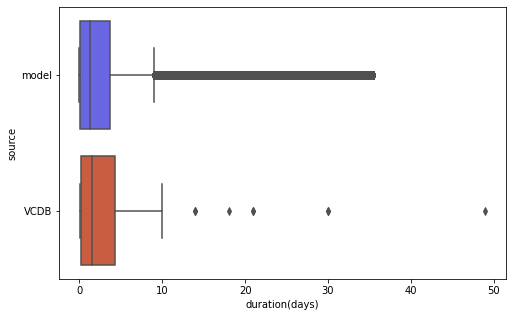

In [69]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.boxplot(data=plot_data, x='duration', y='source', orient='h',ax=ax)
ax.set_xlabel('duration(days)')
fig.savefig('img/duration_box_plot.png')

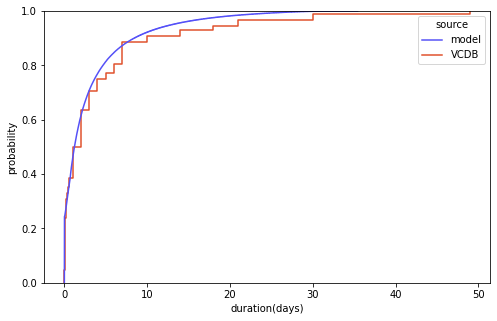

In [29]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.ecdfplot(data=plot_data, x='duration',hue='source',stat='proportion',ax=ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('duration(days)')
ax.set_ylabel('probability')
# ax.axvspan(xmin=15,xmax=23,alpha=0.2,color='grey',linestyle='dashed',lw=1)
# ax.annotate('avg duration of downtime after ransomware attack(statista): 15-23 days', xy=(23, 0.4), xytext=(30, 0.4),xycoords='data',bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             arrowprops=dict(arrowstyle="->"))
fig.savefig('img/duration_ecdf_plot.png')

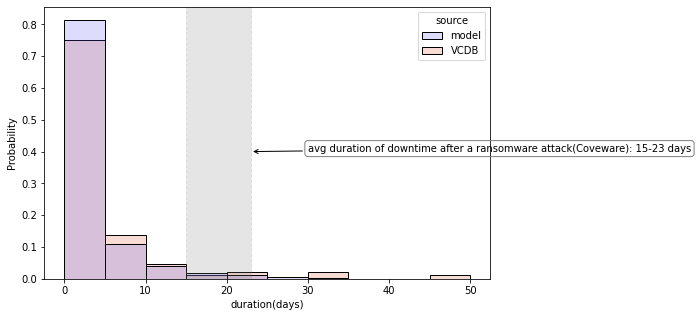

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.histplot(data=plot_data, x='duration', hue='source', stat='probability', binwidth=5, alpha=0.2, common_norm=False, ax=ax)
ax.axvspan(xmin=15,xmax=23,alpha=0.2,color='grey',linestyle='dashed',lw=1)
ax.annotate('avg duration of downtime after a ransomware attack(Coveware): 15-23 days', xy=(23, 0.4), xytext=(30, 0.4),xycoords='data',bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->"))
ax.set_xlabel('duration(days)')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
fig.savefig('img/duration_histogram.png', bbox_inches='tight')